<a href="https://colab.research.google.com/github/NanzibaBasnin/Regenerative_Fish_Firming/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving augmented_dataset (1).zip to augmented_dataset (1).zip


In [ ]:
import os

old_filename = 'augmented_dataset (1).zip'
new_filename = 'augmented_dataset.zip'

if os.path.exists(old_filename):
    os.rename(old_filename, new_filename)
    print(f"Renamed '{old_filename}' to '{new_filename}'")
else:
    print(f"File '{old_filename}' not found")


Renamed 'augmented_dataset (1).zip' to 'augmented_dataset.zip'


In [ ]:
!unzip augmented_dataset.zip


Archive:  augmented_dataset.zip
   creating: augmented_dataset/
   creating: augmented_dataset/Dabberlocks/
  inflating: augmented_dataset/Dabberlocks/image10_0_1450.jpg  
  inflating: augmented_dataset/Dabberlocks/image15_0_731.jpg  
  inflating: augmented_dataset/Dabberlocks/image11_0_8380.jpg  
  inflating: augmented_dataset/Dabberlocks/image9_0_3560.jpg  
  inflating: augmented_dataset/Dabberlocks/image7_0_8857.jpg  
  inflating: augmented_dataset/Dabberlocks/image2_0_7147.jpg  
  inflating: augmented_dataset/Dabberlocks/image1_0_8633.jpg  
  inflating: augmented_dataset/Dabberlocks/image3_0_7407.jpg  
  inflating: augmented_dataset/Dabberlocks/image0_0_5704.jpg  
  inflating: augmented_dataset/Dabberlocks/image13_0_4992.jpg  
  inflating: augmented_dataset/Dabberlocks/image6_0_1770.jpg  
  inflating: augmented_dataset/Dabberlocks/image12_0_3290.jpg  
  inflating: augmented_dataset/Dabberlocks/image4_0_3682.jpg  
  inflating: augmented_dataset/Dabberlocks/image5_0_5954.jpg  
  infl

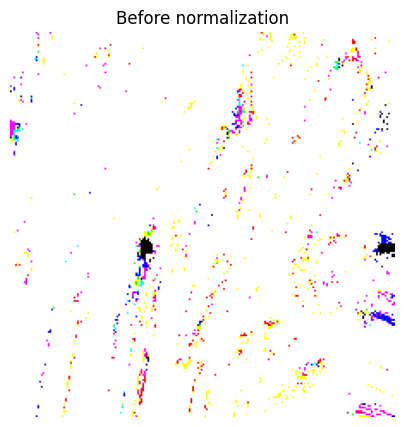

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, compute_sample_weight

# Load dataset
def load_images_labels(data_dir):
    images = []
    labels = []
    for species in os.listdir(data_dir):
        species_dir = os.path.join(data_dir, species)
        if os.path.isdir(species_dir):
            for img_file in os.listdir(species_dir):
                img_path = os.path.join(species_dir, img_file)
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(species)
    return np.array(images), np.array(labels)

data_dir = '/content/augmented_dataset'  # Change this to the path of your dataset folder
images, labels = load_images_labels(data_dir)
import matplotlib.pyplot as plt

def plot_images(image_list, titles):
    if len(image_list) == 1:
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes = [axes]  # Convert the single Axes object to a list to make the code consistent
    else:
        fig, axes = plt.subplots(1, len(image_list), figsize=(15, 15))

    for i, ax in enumerate(axes):
        img = image_list[i]
        if img.min() < 0:  # If the image has negative values, clip them for visualization purposes
            img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
    plt.show()


# Display example image before normalization
example_image = images[0]
plot_images([example_image], ['Before normalization'])





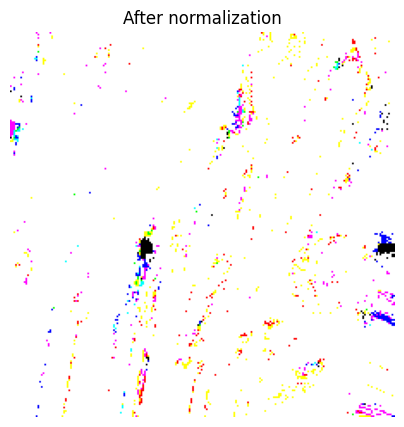

In [ ]:
# Normalize images
images = images / 255.0

# Display example image after normalization
plot_images([example_image], ['After normalization'])


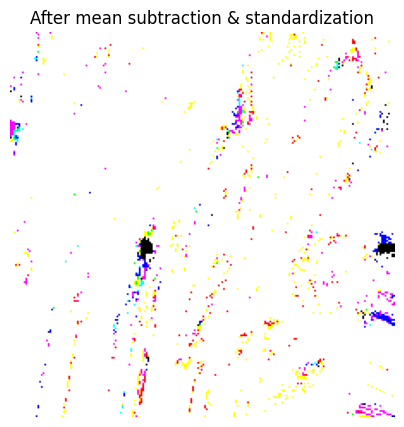

In [ ]:
# Mean subtraction and standardization
mean = np.mean(images)
std = np.std(images)
images = (images - mean) / std

# Display example image after mean subtraction & standardization
plot_images([example_image], ['After mean subtraction & standardization'])

In [ ]:
# One-hot encoding
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

In [ ]:
# Data splitting
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_onehot, test_size=0.3, stratify=labels_onehot, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
# Data balancing
# You can use either oversampling or undersampling techniques. Here, we will use the TensorFlow's `ImageDataGenerator` for oversampling
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
!pip install keras_applications


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
#from keras_applications import convnext
from tensorflow.keras.applications.resnet_v2 import ResNet50V2#
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Load the ResNet50V2 model with ImageNet pre-trained weights
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes =7
# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a new classifier on top of the pre-trained layers
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define the callbacks
checkpoint = ModelCheckpoint(
    "best_model_weights.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

# Train the model with the pre-trained weights frozen
epochs = 100
batch_size = 32

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs,
    steps_per_epoch=len(X_train) // batch_size,
    callbacks=[checkpoint, early_stopping]
)

# Fine-tune the model with the pre-trained weights unfrozen




94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

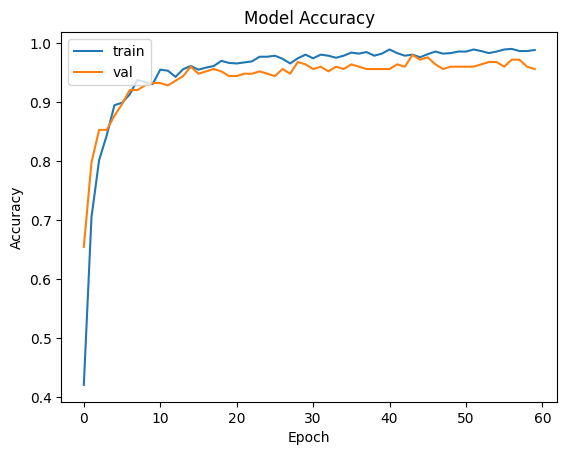

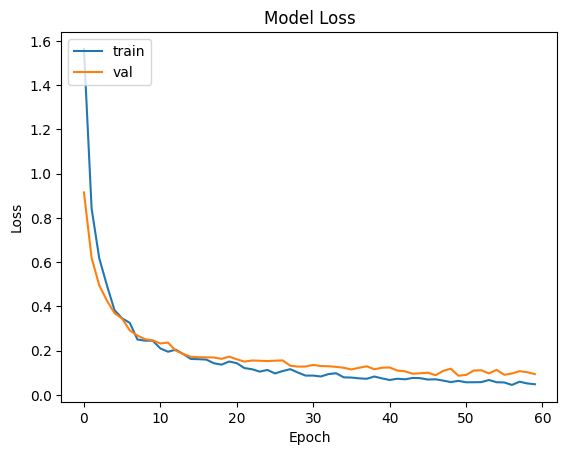

In [ ]:
import matplotlib.pyplot as plt

# Plot the model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


8/8 [==============================] - 48s 6s/step
Confusion Matrix:
[[41  0  0  0  0  0  0]
 [ 0 41  0  0  1  0  0]
 [ 0  0 41  0  0  0  0]
 [ 0  1  0 31  0  0  0]
 [ 0  0  0  0 33  0  0]
 [ 0  1  0  0  0 29  0]
 [ 0  0  0  0  0  0 33]]


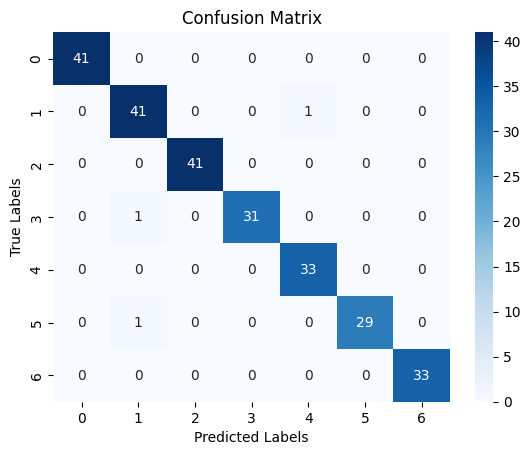

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.95      0.98      0.96        42
           2       1.00      1.00      1.00        41
           3       1.00      0.97      0.98        32
           4       0.97      1.00      0.99        33
           5       1.00      0.97      0.98        30
           6       1.00      1.00      1.00        33

    accuracy                           0.99       252
   macro avg       0.99      0.99      0.99       252
weighted avg       0.99      0.99      0.99       252

Precision: 0.9891538010553058
Recall: 0.9873724489795919
F1 Score: 0.988136905829032


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined and trained your model
# and you have X_test and y_test prepared

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Create the color-coded confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


In [ ]:
# Add a new classifier on top of the pre-trained layers
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
checkpoint = ModelCheckpoint(
    "best_model_weights2.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    mode="min",
    restore_best_weights=True
)


In [ ]:
epochs = 100
batch_size = 32

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs,
    steps_per_epoch=len(X_train) // batch_size,
    callbacks=[checkpoint, early_stopping]
)

